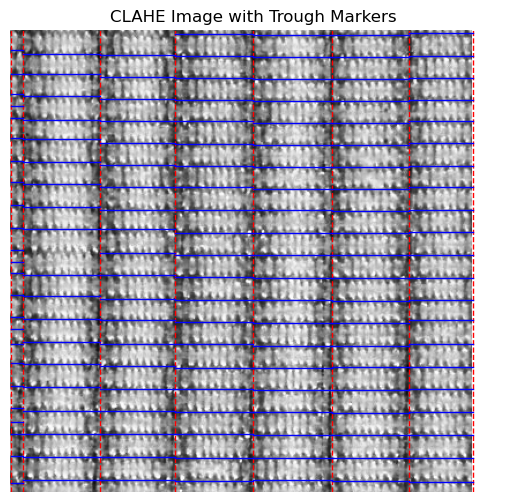

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

# Read and crop the image
img = cv2.imread('../image/img_03.tif')[200:600, 200:600]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_gray)

# Compute mean intensity per column
column_means_clahe = np.mean(img_clahe, axis=0)

# Find troughs
split_troughs, _ = find_peaks(-column_means_clahe, prominence=5, distance=10, height=-155)
s_p = np.concatenate(([0], split_troughs, [img_clahe.shape[1]]))

# Find horizontal troughs within vertical slices
median_troughs_array = []  
for i in range(len(s_p) - 1):
    median_values = np.median(img_clahe[:, s_p[i]:s_p[i + 1]], axis=1)
    sg_medians = savgol_filter(median_values, window_length=12, polyorder=2)
    troughs, _ = find_peaks(-sg_medians, distance=10, height=-155)
    median_troughs_array.append(troughs)

# Plot image and vertical lines at split points
plt.figure(figsize=(10, 6))
plt.imshow(img_clahe, cmap='gray')

for x in s_p:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1)

for i, median_troughs in enumerate(median_troughs_array):
    for median in median_troughs:
        plt.plot([s_p[i], s_p[i + 1]], [median, median], color='blue', linestyle='-', linewidth=1)

plt.title('CLAHE Image with Trough Markers')
plt.axis('off')
plt.show()


In [2]:
median_troughs_array

[array([ 17,  38,  55,  65,  76,  93, 113, 131, 151, 171, 190, 200, 210,
        229, 248, 258, 271, 288, 308, 327, 339, 349, 368, 392], dtype=int64),
 array([ 20,  38,  57,  77,  94, 114, 133, 153, 172, 212, 230, 250, 270,
        289, 309, 329, 349, 369, 389], dtype=int64),
 array([ 21,  40,  59,  78,  97, 116, 135, 155, 172, 193, 212, 232, 251,
        271, 290, 310, 329, 349, 369, 389], dtype=int64),
 array([  3,  22,  41,  60,  78,  98, 117, 135, 155, 175, 194, 213, 233,
        252, 271, 292, 310, 330, 349, 370, 390], dtype=int64),
 array([  4,  23,  42,  61,  80,  99, 118, 137, 155, 175, 194, 214, 233,
        253, 273, 292, 311, 330, 350, 370, 389], dtype=int64),
 array([  4,  23,  42,  61,  80,  99, 118, 137, 156, 175, 194, 214, 234,
        253, 273, 291, 311, 331, 350, 370, 390], dtype=int64),
 array([  2,  22,  41,  60,  78,  97, 117, 135, 155, 174, 194, 214, 233,
        251, 271, 291, 310, 330, 350, 370, 391], dtype=int64)]

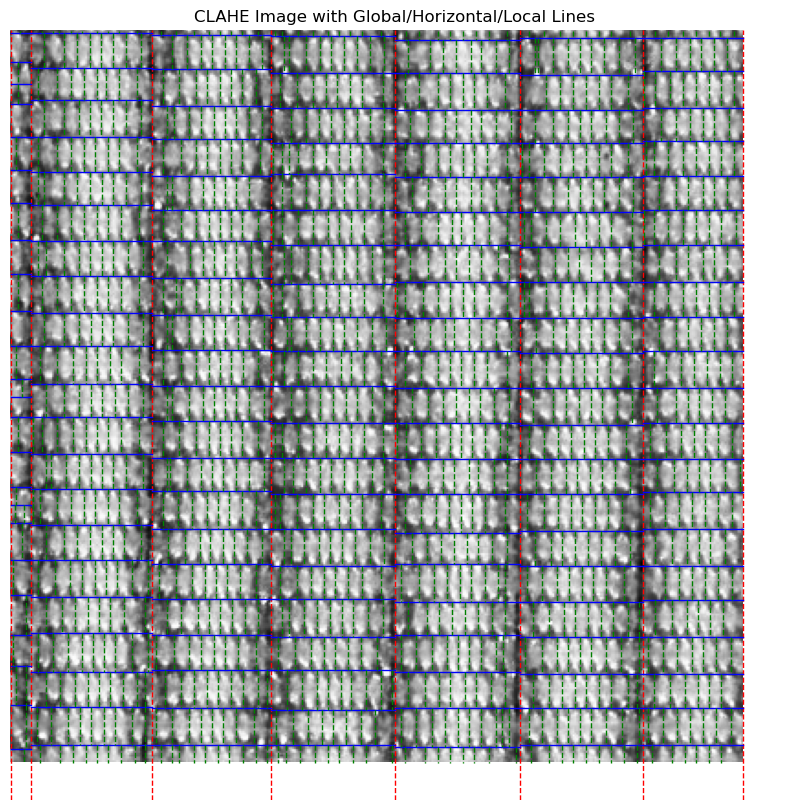

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

# Read and crop the image
img = cv2.imread('../image/img_03.tif')[200:600, 200:600]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_gray)

# Step 1: Find global vertical splits
column_means = np.mean(img_clahe, axis=0)
split_x, _ = find_peaks(-column_means, prominence=17, distance=10, height=-190)
vertical_troughs_array = np.concatenate(([0], split_x, [img_clahe.shape[1]]))

# Step 2: Find horizontal troughs within each vertical slice
horizontal_troughs_array = []  
for i in range(len(vertical_troughs_array) - 1):
    roi = img_clahe[:, vertical_troughs_array[i]:vertical_troughs_array[i+1]]
    row_means = np.mean(roi, axis=1)
    split_y, _ = find_peaks(-row_means, prominence=5, distance=10, height=-155)
    split_y = np.concatenate(([0], split_y, [roi.shape[0]]))
    horizontal_troughs_array.append(split_y)

# Step 3: Find local vertical troughs inside each rectangle
local_troughs_array = []  # 3D list to store local vertical troughs by column and row

for i in range(len(vertical_troughs_array) - 1):
    roi = img_clahe[:, vertical_troughs_array[i]:vertical_troughs_array[i+1]]
    split_y = horizontal_troughs_array[i]

    # Initialize the list for this vertical sector
    vertical_column_lines = []

    # Loop through horizontal slices and find vertical troughs for each slice
    for j in range(len(split_y) - 1):
        top, bottom = split_y[j], split_y[j+1]

        if bottom <= top:
            vertical_column_lines.append([])
            continue

        roi_small = roi[top:bottom, :]
        if roi_small.size == 0:
            vertical_column_lines.append([])
            continue

        col_means_small = np.mean(roi_small, axis=0)
        smoothed_cols = savgol_filter(col_means_small, window_length=5, polyorder=2)
        vertical_troughs, _ = find_peaks(-smoothed_cols)

        # Store x-coordinates of vertical troughs for each column
        vertical_column_lines.append(vertical_troughs.tolist())

    # Store the vertical troughs for this vertical slice
    local_troughs_array.append(vertical_column_lines)

# Step 4: Plotting
plt.figure(figsize=(12, 10))
plt.imshow(img_clahe, cmap='gray')

# Plot global vertical split lines (red dashed)
for x in vertical_troughs_array:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1)

# Plot horizontal split lines (blue solid)
for i in range(len(horizontal_troughs_array)):
    for y in horizontal_troughs_array[i][1:-1]:  # skip 0 and max height
        plt.plot([vertical_troughs_array[i], vertical_troughs_array[i+1]], [y, y], color='blue', linestyle='-', linewidth=1)

# Plot local vertical lines (green dashed)
for i in range(len(local_troughs_array)):
    split_y = horizontal_troughs_array[i]
    for j in range(len(local_troughs_array[i])):
        top, bottom = split_y[j], split_y[j+1]
        for x in local_troughs_array[i][j]:
            plt.plot([x + vertical_troughs_array[i], x + vertical_troughs_array[i]], [top, bottom], color='green', linestyle='--', linewidth=1)

plt.title('CLAHE Image with Global/Horizontal/Local Lines')
plt.axis('off')
plt.show()


In [23]:
horizontal_troughs_array

[array([  0,   1,  17,  29,  40,  58,  76,  94, 114, 133, 153, 172, 190,
        200, 211, 230, 249, 259, 269, 289, 308, 330, 347, 368, 392, 400],
       dtype=int64),
 array([  0,   1,  20,  38,  58,  77,  95, 115, 134, 154, 172, 193, 211,
        231, 250, 270, 289, 309, 329, 350, 369, 390, 400], dtype=int64),
 array([  0,   2,  21,  41,  59,  79,  98, 115, 135, 155, 174, 194, 213,
        233, 251, 272, 291, 310, 330, 349, 370, 390, 400], dtype=int64),
 array([  0,   3,  23,  42,  61,  78,  98, 117, 138, 156, 175, 194, 214,
        233, 253, 272, 292, 310, 331, 349, 371, 390, 400], dtype=int64),
 array([  0,   5,  23,  43,  61,  80,  99, 117, 137, 157, 175, 195, 214,
        234, 253, 274, 291, 312, 330, 350, 370, 391, 400], dtype=int64),
 array([  0,   4,  24,  43,  61,  80,  99, 118, 137, 157, 176, 195, 215,
        234, 253, 273, 292, 312, 331, 351, 370, 390, 400], dtype=int64),
 array([  0,   4,  22,  42,  60,  79,  98, 117, 137, 156, 175, 195, 214,
        234, 252, 272, 292, 3

In [25]:
local_troughs_array

[[[5],
  [],
  [4],
  [4],
  [],
  [3],
  [],
  [4],
  [],
  [4],
  [],
  [3],
  [6],
  [],
  [4],
  [],
  [3],
  [2, 7],
  [6],
  [1],
  [8],
  [1],
  [3, 8],
  [8],
  [7]],
 [[6, 12, 15, 22, 28, 36, 42, 48, 58],
  [7, 18, 25, 32, 38, 45, 52, 60],
  [4, 14, 22, 29, 36, 41, 48, 58],
  [7, 18, 26, 32, 38, 45, 52, 60],
  [4, 14, 22, 29, 35, 42, 48, 58],
  [4, 7, 18, 25, 32, 39, 45, 52, 60],
  [6, 14, 22, 29, 36, 42, 49, 59],
  [4, 8, 18, 26, 32, 39, 45, 53, 61],
  [6, 14, 22, 29, 36, 42, 49, 59],
  [7, 18, 26, 33, 39, 45, 53, 61],
  [5, 14, 23, 30, 36, 43, 49, 59],
  [8, 18, 26, 33, 39, 46, 53, 61],
  [1, 6, 14, 23, 30, 36, 42, 49, 59],
  [8, 11, 19, 26, 33, 39, 45, 52, 61],
  [1, 5, 14, 22, 29, 35, 42, 48, 58],
  [8, 18, 25, 32, 39, 45, 51, 60],
  [4, 13, 21, 28, 35, 41, 47, 55, 64],
  [8, 17, 24, 31, 37, 43, 51, 62],
  [4, 12, 20, 28, 34, 40, 46, 55, 64],
  [8, 16, 24, 31, 37, 43, 50, 58, 62],
  [3, 11, 20, 27, 33, 40, 46, 55, 62],
  [5, 16, 23, 30, 36, 42, 49, 57, 62]],
 [[5, 13, 23, 